In [1]:
import pandas as pd
import numpy as np
import torch
import torchmetrics
import typing
from matplotlib import pyplot as plt
%matplotlib inline
from math import isclose

In [2]:
from data_utils import get_csv_data, diff_seq


In [3]:
# get data
data = get_csv_data(folder_path="./raw_data")

In [4]:
difference = [diff_seq(full_seq["C"], 1, same_length=True) for i, full_seq in enumerate(data)]

No handles with labels found to put in legend.
C:\Users\Jacky\miniconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with lab

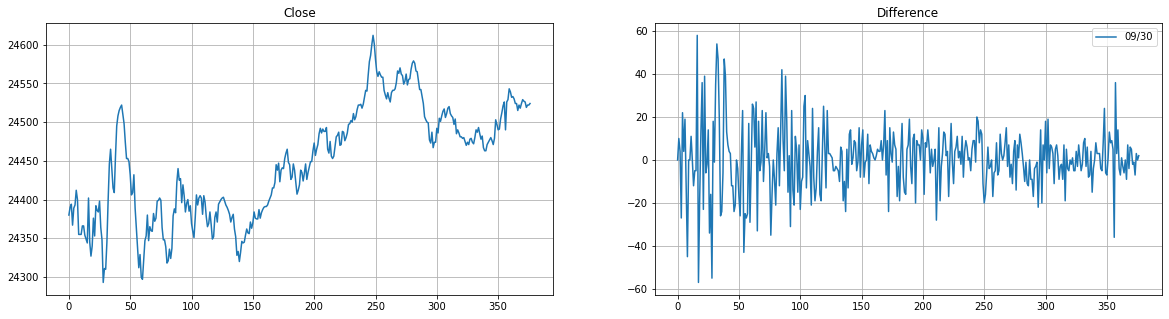

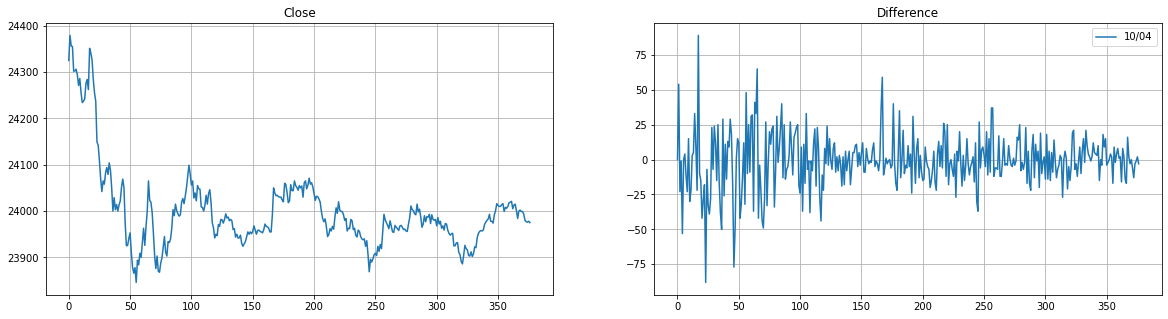

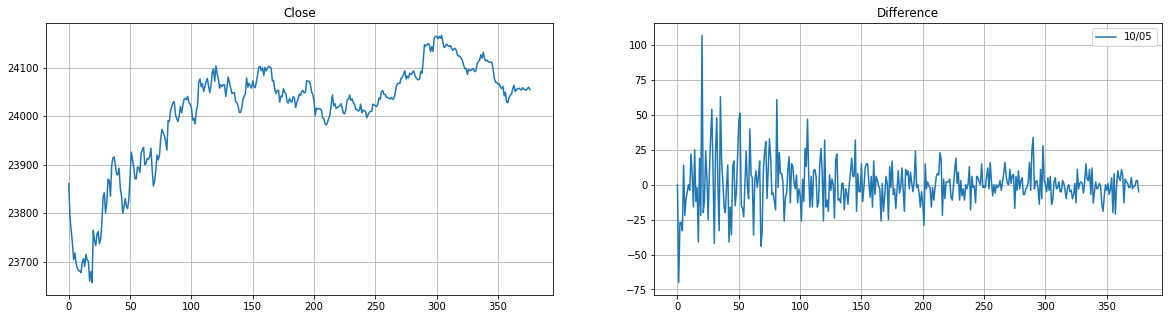

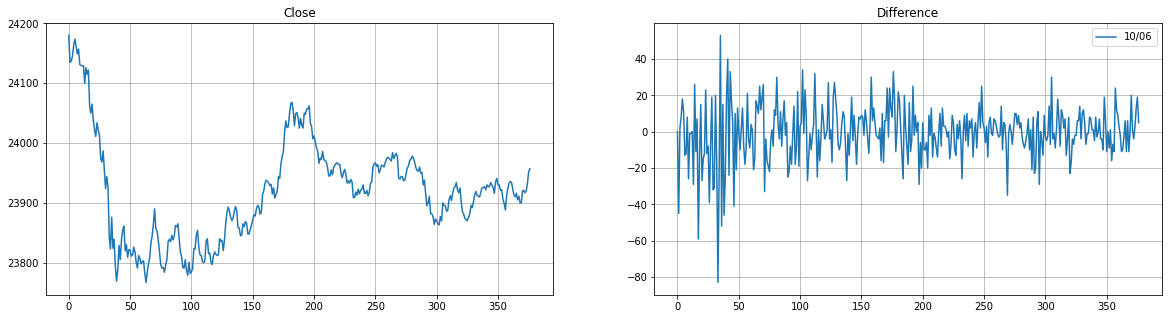

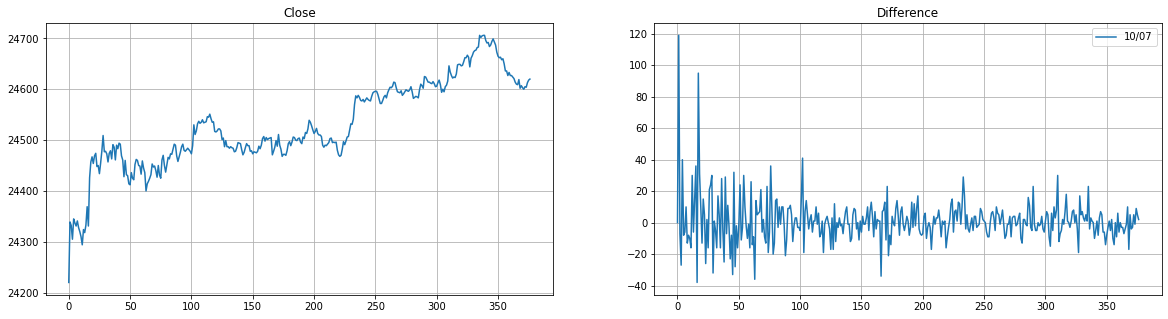

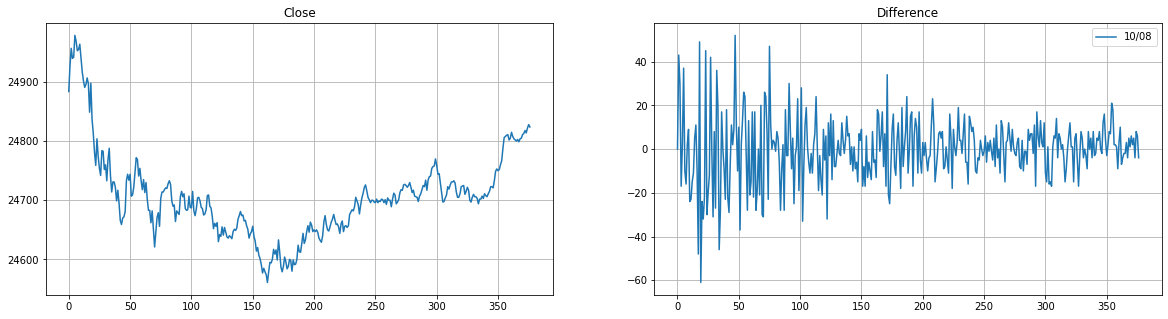

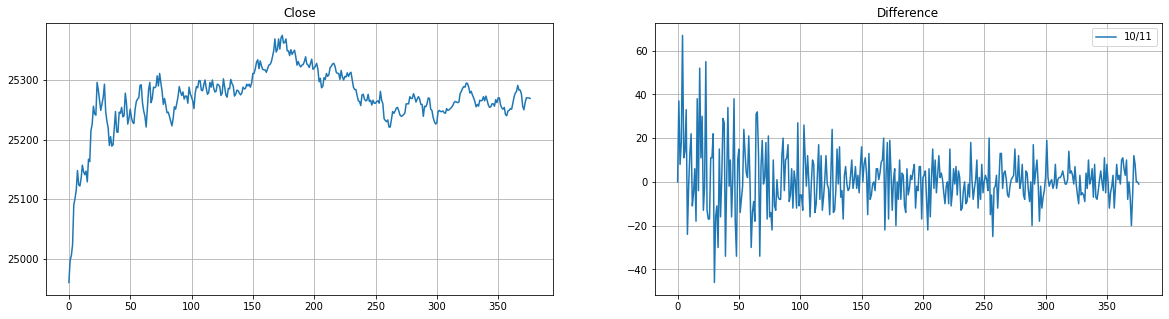

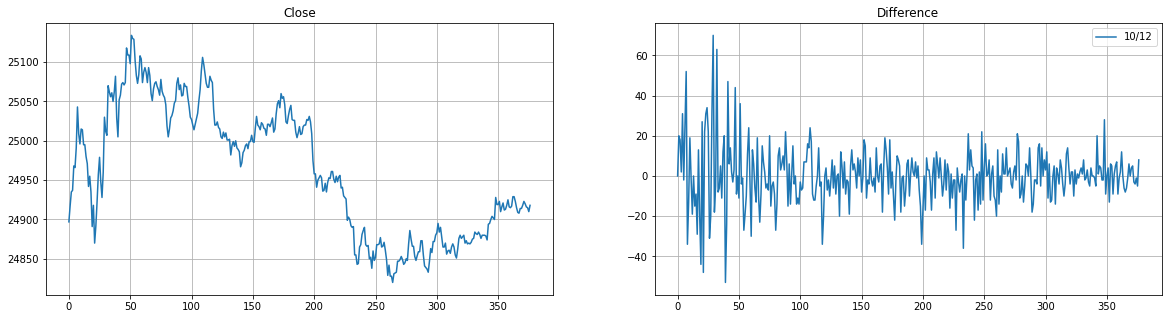

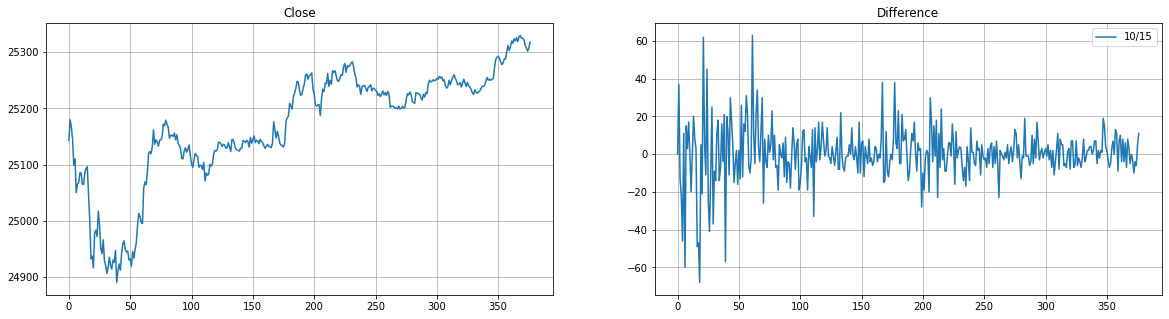

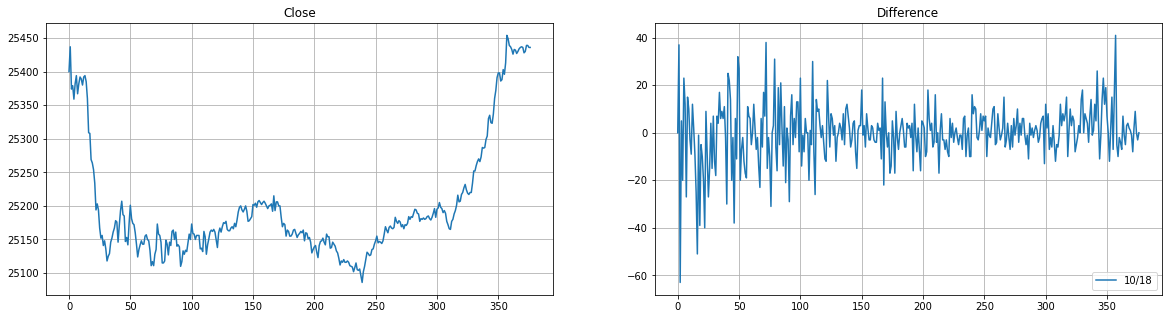

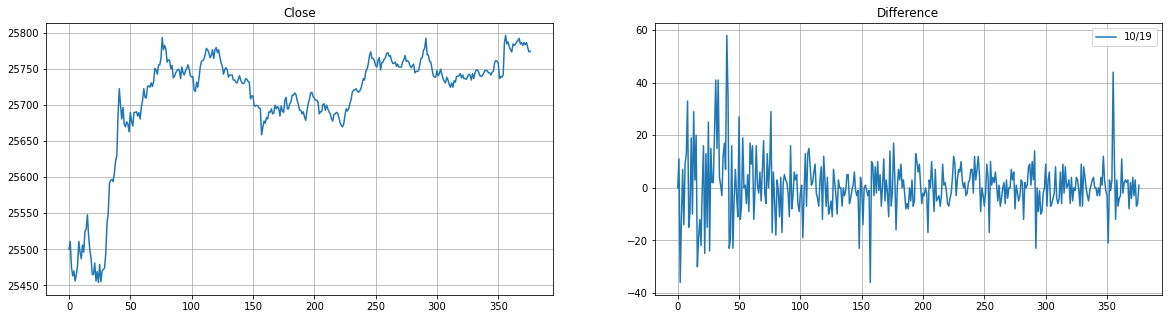

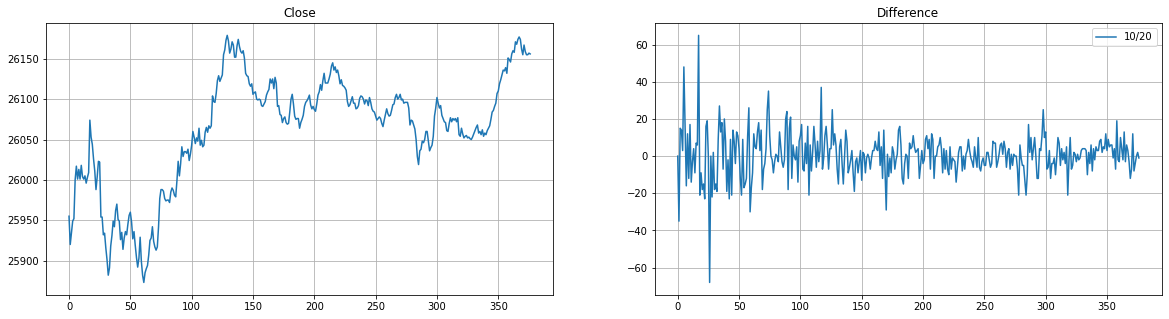

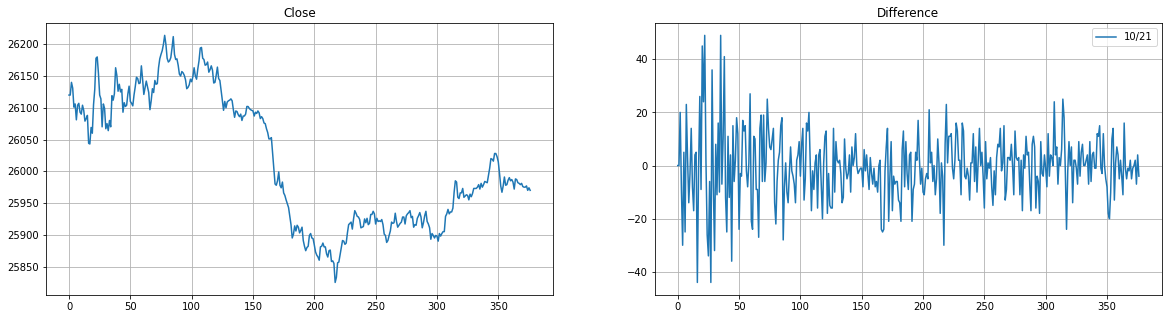

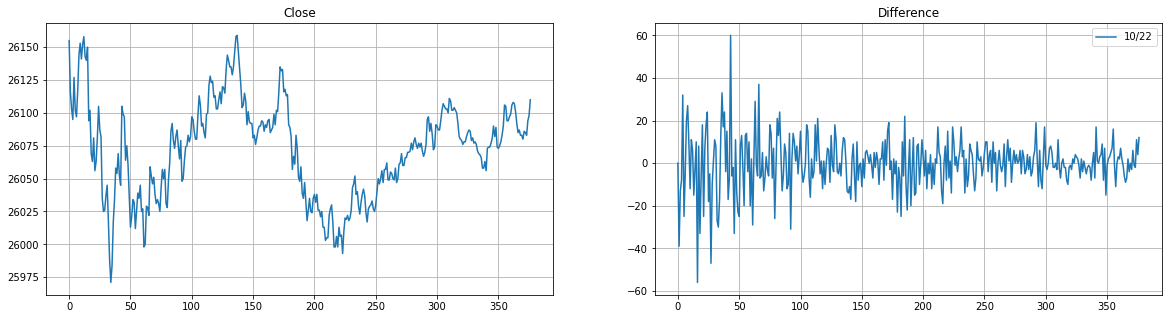

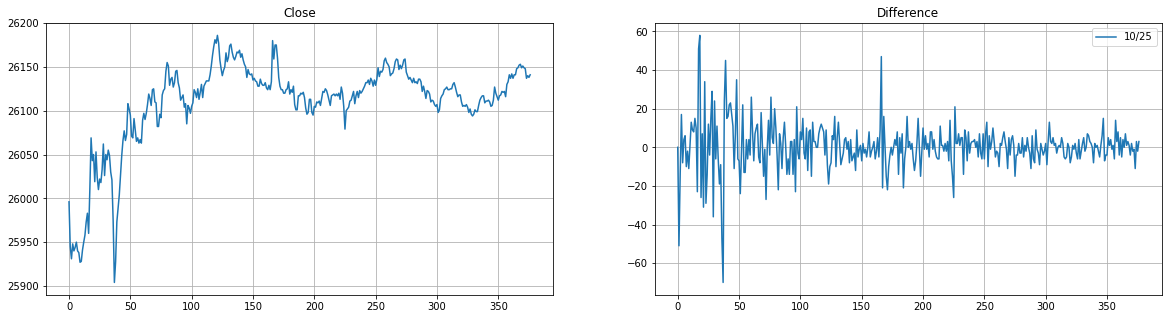

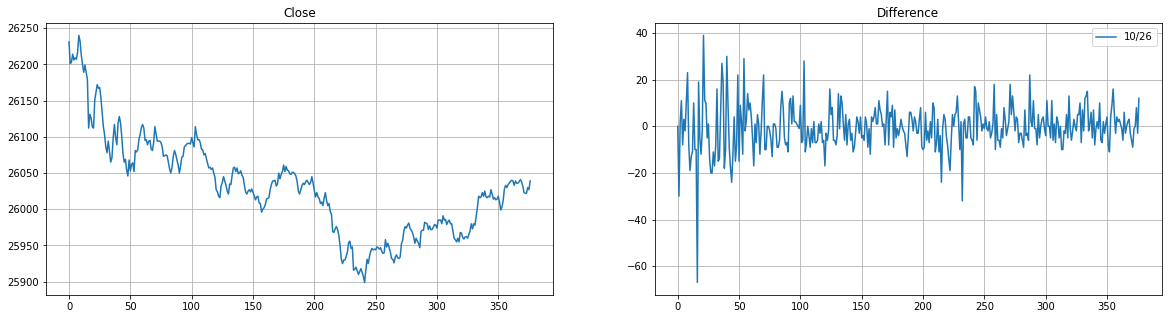

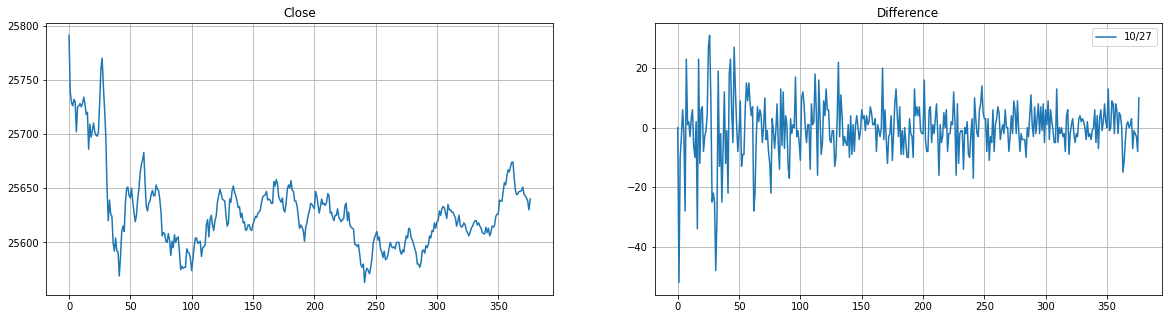

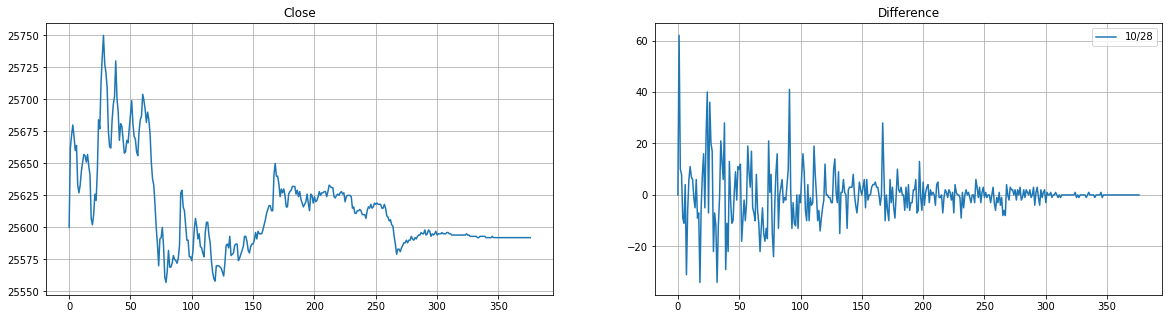

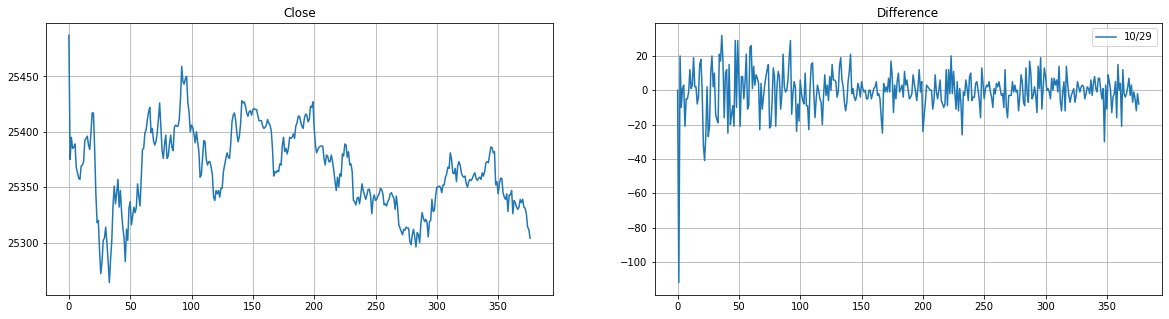

In [5]:
for i, seq in enumerate(difference): 
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax1.plot(data[i]["C"], label=f"{data[i]['Date'][0]}")
    ax1.grid(True)
    ax1.set_title("Close")
    ax2.legend()
    ax2.plot(seq, label=f"{data[i]['Date'][0]}")
    ax2.grid(True)
    ax2.set_title("Difference")
    ax2.legend()
    fig.show()

In [6]:
# dataloader
class StockData(torch.utils.data.Dataset):

    def __init__(self, features, targets):
        self.targets = torch.tensor(targets)  # cast targets to tensor
        self.features = torch.tensor(features)  # calculates total count of unique targets

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

    def __len__(self):
        return len(self.targets)

    def split(self, *split_ratio): 
        '''
        returns torch random split object (this instance) \n
        if numbers > 1 are given: check if sum == len, then pass to torch.utils.data.random_split \n
        if numbers < 1 are given: then the sum must == 1, then compute the length og each portion \n
        '''
        summed = sum(split_ratio)
        if not isclose(summed, 1.0):  # or and abs( 1-sum(split_ratio) ) > 1e-15
            if summed != len(self): # check if the sum == len
                raise ValueError(
                    f"sum of splitted lengths does not match the data length\ninstead of the total of {len(self)} or total ratio of 1, {split_ratio} -> {sum(split_ratio)} were given")  
            self.sizes = split_ratio
        else:  # if sum == 1
            self.sizes = [ int( ratio*len(self) ) for ratio in split_ratio[:-1] ]  # leave one out, the left will be the last term, so that dun need to deal with the rounding problem 
            self.sizes.append(len(self) - sum(self.sizes))  # add the rest instead of the length*ratio, for the last term
        return torch.utils.data.random_split(self, self.sizes)

    def dataloader(self, *args, **kwargs: typing.Any):
        return torch.utils.data.DataLoader(self, *args, **kwargs)

In [7]:
class Encoder(torch.nn.Module):
    def __init__(
        self,
        seq_length,
        n_features,
        output_length,
        hidden_size,
        num_layers: int = 1,
        batch_first: bool = False,
        dropout: float = 0,
        bidirectional: bool = False,
        add_linear: bool = False
    ):
        super().__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.output_length = output_length
        self.n_direction = 2 if bidirectional else 1
        self.add_linear = add_linear
        self.LSTM = torch.nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if add_linear:
            self.linear = torch.nn.Linear(
                self.LSTM.hidden_size * self.n_direction,
                self.output_length
            )

    def forward(self, seq):
        # for this case (BATCH_FIRST),
        # seq dim is (batch, seq_length, n_features), check using torch.randn(bitch_size, seq_length, n_features)
        # output is seq, (h_n, c_n) having dim as:
        # (batch, seq_length, n_features*self.D)
        # (batch, self.D*num_layers, hidden_size) since proj_size is set 0 here otherwise it s proj_size
        # (batch, self.D*num_layers, hidden_size)
        if self.add_linear:
            _, (h_n, _) = self.LSTM(X)
            # reshape the h_n (last output) to (num_layer, n_direction, batch=-1 (-1 means all), hidden_size)
            # get the last one, which is the last layer from the h_n
            # then get rid of the num_layer, as we chose the last layer, hence squeeze(dim=0)
            h_n = h_n.reshape(
                self.LSTM.num_layers,
                self.n_direction,
                -1,
                self.LSTM.hidden_size
            )[-1].squeeze(dim=0)
            # if LSTM is bidirectional, concat the 2 direction outputs (last layer of h_n)
            # from above, h_n now has the shape of (n_direction, batch, hidden_size)
            # so h_n[0] is 1 direction, h_n[1] is the other, size of (batch, hidden_size)
            # concat about the hidden_size can keep the batch size no changed
            # hence output the size of (batch, n_direction * hidden_size)
            if self.LSTM.bidirectional: 
                h_n = torch.cat((h_n[0], h_n[1]), dim=-1)
            else:
                h_n = h_n.squeeze(dim=0)
            return self.linear(h_n)
        else: 
            output, (h_n, c_n) = self.LSTM(X)
            return output, (h_n, c_n)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_data = np.array([])
target_data = np.array([])
n_features = 1  # this fixed for now
for i, (X, y) in enumerate(zip(data[:-1], data[1:])):
    X, y = X[["C"]].to_numpy(dtype=np.float32), y[["C"]].to_numpy(dtype=np.float32)
    input_data = np.append(input_data, X).reshape(i+1, len(X), n_features)
    target_data = np.append(target_data, y).reshape(i+1, len(y), n_features)

ready_data = StockData(features=input_data, targets=target_data)
train, test, val = ready_data.split(*[0.7, 0.2, 0.1])

len(train), len(val), len(test)

(12, 3, 3)

In [9]:
params = {
    'seq_length': 377,
    'n_features': 1,
    'output_length': 377,
    'hidden_size': 3,
    'num_layers': 3,
    'batch_first': True,
    'dropout': 0.5,
    'bidirectional': False,
    'add_linear': True
}
rnn = Encoder(**params).to(device)

epoch 0 train: 699037.1875
epoch 0 test: 831517.3125


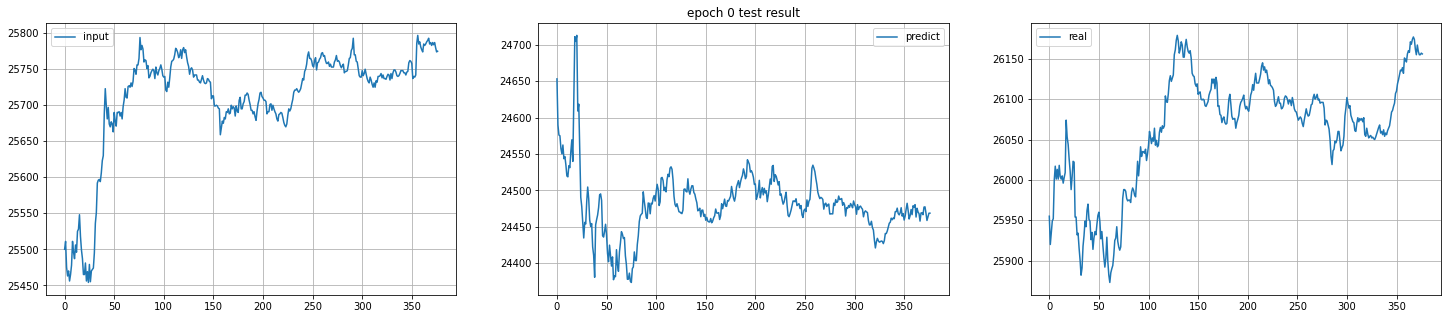

KeyboardInterrupt: 

In [15]:
# parmas for training loop
n_epochs = 500
run_params = {
    "batch_size": 1
}
record_period = 100

# loss function, optimiser and metrics 
loss_func = torch.nn.MSELoss().to(device)
optimiser = torch.optim.Adam(rnn.parameters(), lr=1000)
metrics = torchmetrics.MeanSquaredError().to(device)


for epoch in range(n_epochs): 
    # training
    for X, y in torch.utils.data.DataLoader(train, **run_params):
        # RNN here
        X, y = X.float().to(device), y.float().to(device)
        # y = y.squeeze(0)
        outputs = rnn(X)
        loss = loss_func(outputs.flatten(), y.flatten())
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        metrics(outputs.flatten(), y.flatten())
    met = metrics.compute()
    if epoch%record_period == 0: 
        print(f'epoch {epoch} train: {met}')

    # test
    for X, y in torch.utils.data.DataLoader(test, **run_params):
        # RNN here
        X, y = X.float().to(device), y.float().to(device)
        # y = y.squeeze(0)
        outputs = rnn(X)
        metrics(outputs.flatten(), y.flatten())
    met = metrics.compute()
    if epoch%record_period == 0: 
        print(f'epoch {epoch} test: {met}')

        X_input = torch.flatten(X.cpu().detach())
        X_pred = torch.flatten(outputs.cpu().detach())
        y = torch.flatten(y.cpu().detach())

        fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
        ax1.plot(X_input, label="input")
        ax1.legend()
        ax1.grid(True)
        ax2.plot(X_pred, label="predict")
        ax2.legend()
        ax2.grid(True)
        ax2.set_title(f"epoch {epoch} test result")
        ax3.plot(y, label="real")
        ax3.legend()
        ax3.grid(True)
        plt.show()


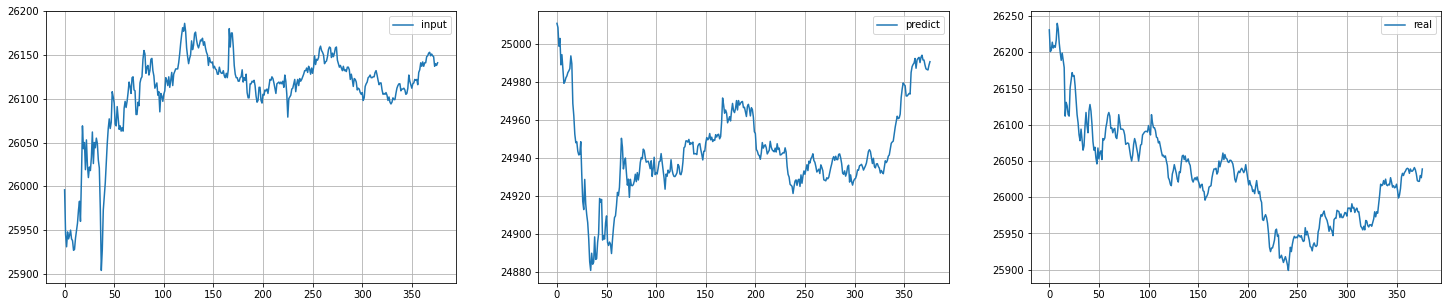

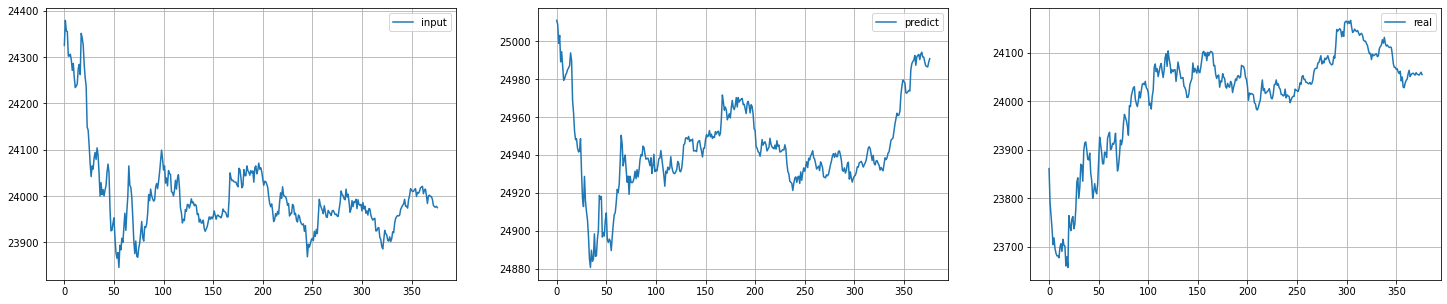

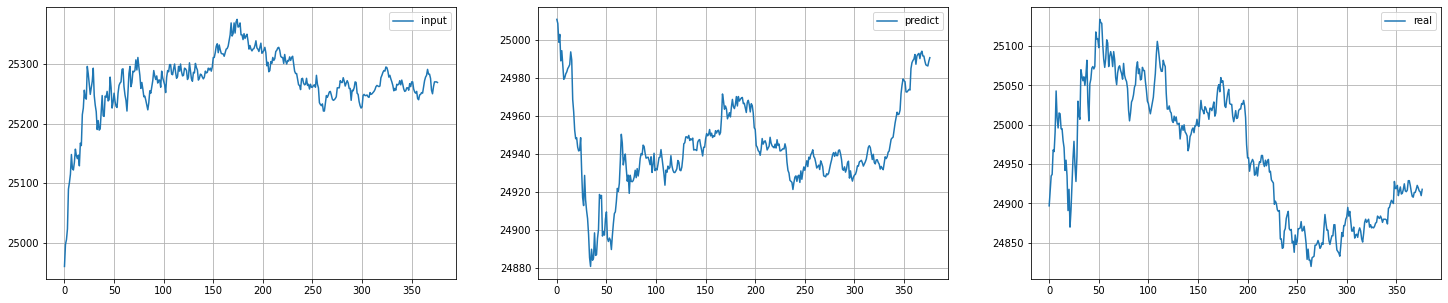

In [16]:
validation = torch.utils.data.DataLoader(val, **run_params)
for i, (X, y) in enumerate(validation): 
    X, y = X.float().to(device), y.float().to(device)
    output = rnn(X)

    X_input = torch.flatten(X.cpu().detach())
    X_pred = torch.flatten(output.cpu().detach())
    y = torch.flatten(y.cpu().detach())

    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    ax1.plot(X_input, label="input")
    ax1.legend()
    ax1.grid(True)
    ax2.plot(X_pred, label="predict")
    ax2.legend()
    ax2.grid(True)
    ax3.plot(y, label="real")
    ax3.legend()
    ax3.grid(True)
    plt.show()